Checking Transferibility of CG-Vec

CG Construction

In [1]:
import csv, functools, json, warnings, re
import os, random
import numpy as np
import torch
from torch.utils.data import Dataset
from pymatgen.core import Element, Structure, Lattice
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

class GaussianDistance(object):
    def __init__(self, dmin, dmax, step, var=None):
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax + step, step)
        self.var = step if var is None else var

    def expand(self, distances):
        return np.exp(-(distances[..., np.newaxis] - self.filter) ** 2 / self.var ** 2)


class CIFData(Dataset):
    def __init__(self, id_prop_path, magmom_path, eigen_path, ofm_val_comp_path,
             max_num_nbr=12, radius=8, dmin=0, step=0.1, random_seed=123):


        # Load CSV
        with open(id_prop_path) as f:
            reader = csv.reader(f)
            self.id_prop_data = [row for row in reader]

        # Load magnetic moments
        with open(magmom_path) as f:
            self.magmom = json.load(f)

        # Load magnetic moments
        with open(eigen_path) as f:
            self.eigen1 = json.load(f)

        # Load magnetic moments
        with open(ofm_val_comp_path) as f:
            self.ofm_val_comp = json.load(f)

        random.seed(random_seed)
        random.shuffle(self.id_prop_data)

        self.gdf = GaussianDistance(dmin=dmin, dmax=radius, step=step)
        self.max_num_nbr = max_num_nbr
        self.radius = radius

    def __len__(self):
        return len(self.id_prop_data)

    def structure_from_str(self, cif_string):
        cif_lines = cif_string.strip().split('\n')

    # Parse lattice
        a, b, c = map(float, cif_lines[2].split()[2:5])
        alpha, beta, gamma = map(float, cif_lines[3].split()[1:4])

        species, coords = [], []

        reading_atoms = False
        for line in cif_lines:
            line = line.strip()
            if re.match(r'^\d+\s+\w+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+', line):
                reading_atoms = True
            if not reading_atoms:
                continue
            try:
                parts = line.split()
                if len(parts) < 5:
                    continue
                sp = parts[1]
                a_frac, b_frac, c_frac = map(float, parts[2:5])
                species.append(sp)
                coords.append([a_frac, b_frac, c_frac])
            except Exception as e:
                warnings.warn(f"Skipping line due to error: {line} ({e})")
                continue

        lattice = Lattice.from_parameters(a, b, c, alpha, beta, gamma)
        return Structure(lattice, species, coords)


    def featurizer(self, element):
        min_max = [[1.00794, 244.0], [1.0, 118.0], [0.25, 2.6], [-0.72, 3.61272528]]
        lis = ['Atomic mass', 'Atomic no', 'Atomic radius', 'Electron affinity']
        ele = Element(element)
        try:
            fea = [float(str(ele.data[i]).split()[0]) for i in lis]
        except:
            fea = [ele.data['Atomic mass'], ele.data['Atomic no'],
                   ele.data['Atomic radius calculated'], ele.data['Electron affinity']]
        for i in range(4):
            fea[i] = (fea[i] - min_max[i][0]) / (min_max[i][1] - min_max[i][0])
        return fea

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, idx):
        cif_id, cif_string, target = self.id_prop_data[idx]
        crystal = self.structure_from_str(cif_string)

        atom_fea = np.vstack([
            [self.magmom[site.species_string]] + self.ofm_val_comp[site.species_string]
            + self.featurizer(site.species_string)
            for site in crystal
        ])
        atom_fea = torch.Tensor(atom_fea)

        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        nbr_fea_idx, nbr_fea = [], []

        for i, nbr in enumerate(all_nbrs):
            if len(nbr) < self.max_num_nbr:
                warnings.warn(f'{cif_id} atom {i} has only {len(nbr)} neighbors. Consider increasing radius.')
                nbr_fea_idx.append([x[2] for x in nbr] + [0] * (self.max_num_nbr - len(nbr)))
                nbr_fea.append([x[1] for x in nbr] + [self.radius + 1.] * (self.max_num_nbr - len(nbr)))
            else:
                nbr_fea_idx.append([x[2] for x in nbr[:self.max_num_nbr]])
                nbr_fea.append([x[1] for x in nbr[:self.max_num_nbr]])

        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        nbr_fea = torch.Tensor(self.gdf.expand(np.array(nbr_fea)))
        target = torch.Tensor([float(target)])
        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id



CG to Vector

In [2]:
# Add this function below your CIFData class
def graph_to_vector(atom_fea, nbr_fea):
    """
    Convert a graph's atom and neighbor features to a fixed-size vector.
    Includes mean and std pooling over atom and edge features.
    """
    atom_mean = atom_fea.mean(dim=0)
    atom_std = atom_fea.std(dim=0)
    edge_mean = nbr_fea.mean(dim=(0, 1))
    edge_std = nbr_fea.std(dim=(0, 1))

    return torch.cat([atom_mean, atom_std, edge_mean, edge_std], dim=0)  # shape: [2*D_node + 2*D_edge]

# Example usage:
dataset = CIFData(id_prop_path="my_new_data1/all_fm_no_ni.csv", magmom_path="my_new_data1/magmom.json", eigen_path="my_new_data1/eigenvalues_bulk.json",
                   ofm_val_comp_path="my_new_data1/ofm.json")
(graph_data, target, cif_id) = dataset[0]
atom_fea, nbr_fea, nbr_fea_idx = graph_data

fixed_vector = graph_to_vector(atom_fea, nbr_fea)
print("Graph vector shape:", fixed_vector.shape)
print("Graph vector:", fixed_vector)

X = []
y = []      
for (atom_fea, nbr_fea, _), target, cif_id in dataset:
    graph_vec = graph_to_vector(atom_fea, nbr_fea)
    X.append(graph_vec.numpy())  # convert tensor to numpy
    y.append(target.item())      # scalar target



Graph vector shape: torch.Size([236])
Graph vector: tensor([1.8417e+00, 3.0000e-01, 7.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.0000e-01, 0.0000e+00, 0.0000e+00, 1.0000e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6798e-01, 1.5128e-01, 3.8085e-01,
        6.7257e-01, 3.4670e-01, 4.8305e-01, 4.8305e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.1640e-01, 0.0000e+00, 0.0000e+00, 3.1623e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2925e-01, 

C:\Users\Sand\AppData\Local\Temp\ipykernel_19104\1584274555.py:8: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  atom_std = atom_fea.std(dim=0)


training and Testing

✅ Using 10 bins for stratification (min bin size: 1788)
Train: 14305, Val: 1788, Test: 1789
Model saved to trained_cgvec_rf.joblib

=== Results ===
Validation -> R²: 0.9155, CC: 0.9574, MAE: 0.0055
Test       -> R²: 0.9240, CC: 0.9625, MAE: 0.0055


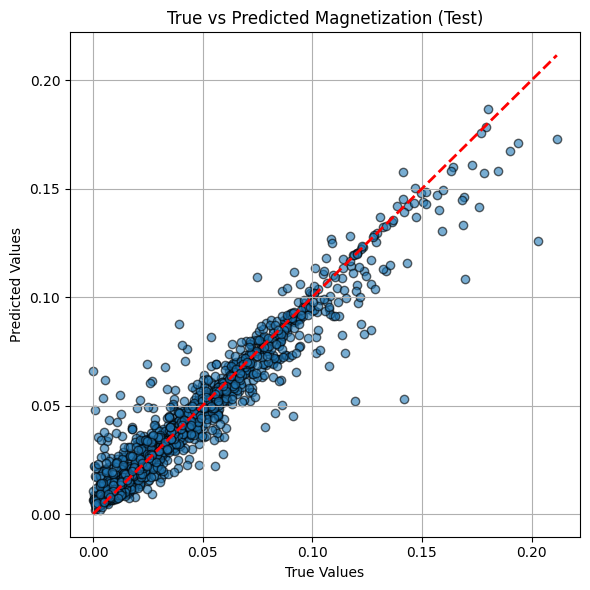

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import joblib   # ADD THIS AT TOP OF FILE 3

# --- Helper to create safe stratification bins ---
def make_safe_stratification_bins(y, min_per_bin=30, max_bins=10):
    """
    Bin continuous target values for stratification.
    Reduces bins until each has at least min_per_bin samples.
    """
    for n_bins in range(max_bins, 1, -1):
        try:
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
            y_binned = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()
            _, counts = np.unique(y_binned, return_counts=True)
            if np.min(counts) >= min_per_bin:
                print(f"✅ Using {n_bins} bins for stratification (min bin size: {np.min(counts)})")
                return y_binned
        except:
            continue
    raise ValueError("❌ Cannot safely bin targets for stratification")

# --- Convert to NumPy arrays ---
X = np.array(X)
y = np.array(y)

# --- Create stratification bins ---
y_binned = make_safe_stratification_bins(y)

# --- First split: 60% train, 40% temp ---
X_train, X_temp, y_train, y_temp, yb_train, yb_temp = train_test_split(
    X, y, y_binned, test_size=0.2, random_state=42, stratify=y_binned
)

# --- Second split: 20% val, 20% test ---
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=yb_temp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- Train model ---
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
# SAVE THE TRAINED MODEL
joblib.dump(model, "all_fm_noni_cgvec_rf.joblib")
print("Model saved to trained_cgvec_rf.joblib")

# --- Validation evaluation ---
y_val_pred = model.predict(X_val)
r2_val = r2_score(y_val, y_val_pred)
cc_val, _ = pearsonr(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

# --- Test evaluation ---
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
cc_test, _ = pearsonr(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\n=== Results ===")
print(f"Validation -> R²: {r2_val:.4f}, CC: {cc_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test       -> R²: {r2_test:.4f}, CC: {cc_test:.4f}, MAE: {mae_test:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('True vs Predicted Magnetization (Test)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()



Predicting Unseen data using Trained Models

In [4]:
import joblib
import numpy as np
import torch

# ------------------------------------------------
# Load trained RandomForest model
# ------------------------------------------------
model = joblib.load("all_fm_noni_cgvec_rf.joblib")
print("Loaded trained model.")

# ------------------------------------------------
# Load unseen dataset
# Format must be identical: each row = (id, cif_string, dummy_value)
# Target is ignored.
# ------------------------------------------------
unseen_dataset = CIFData(
    id_prop_path="my_new_data1/ni_fm.csv",
    magmom_path="my_new_data1/magmom.json",
    eigen_path="my_new_data1/eigenvalues_bulk.json",
    ofm_val_comp_path="my_new_data1/ofm.json",
    max_num_nbr=12,
    radius=8,
    dmin=0,
    step=0.1
)

# ------------------------------------------------
# Build vectors for each unseen material
# ------------------------------------------------for (atom_fea, nbr_fea, _), target, cif_id in unseen_dataset:


Loaded trained model.


In [5]:
# ---------- METRICS + PLOT for unseen predictions ----------
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

out_dir = "cgvec_mapping"
fig_dir = os.path.join(out_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)

# Recompute predictions but also collect true targets (if present)
X_unseen = []
ids = []
y_true = []

for (atom_fea, nbr_fea, _), target, cif_id in unseen_dataset:
    vec = graph_to_vector(atom_fea, nbr_fea)
    X_unseen.append(vec.numpy())
    ids.append(cif_id)
    # target is a torch Tensor([value]) in your CIFData; get scalar
    try:
        y_true.append(float(target.item()))
    except Exception:
        # fallback if target is already float-like
        y_true.append(float(target))

X_unseen = np.array(X_unseen)
y_true = np.array(y_true)

# Predict (use previously loaded model variable)
y_pred = model.predict(X_unseen)

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
cc, _ = pearsonr(y_true, y_pred)

print("\n==== Unseen set performance ====")
print(f"Samples: {len(y_true)}")
print(f"R²   = {r2:.4f}")
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"CC   = {cc:.4f}")

# Save CSV with true/pred/residual
out_csv = os.path.join(out_dir, "unseen_predictions_with_truth.csv")
rows = np.column_stack([ids, y_true, y_pred, (y_true - y_pred)])
np.savetxt(out_csv, rows, fmt="%s", delimiter=",", header="cif_id,true,pred,residual", comments="")
print("Saved predictions + truth →", out_csv)

# Scatter plot: True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', linewidth=0.2)
mn = min(y_true.min(), y_pred.min()); mx = max(y_true.max(), y_pred.max())
pad = 0.02 * (mx - mn) if mx>mn else 0.01
plt.plot([mn-pad, mx+pad], [mn-pad, mx+pad], 'r--', lw=1.5)
plt.xlabel('True Magnetization')
plt.ylabel('Predicted Magnetization')
plt.title('True vs Predicted Magnetization (Unseen set)')
# metrics text box
txt = f"n={len(y_true)}  R²={r2:.3f}  CC={cc:.3f}\nMAE={mae:.6f}  RMSE={rmse:.6f}"
plt.gca().text(0.05, 0.95, txt, transform=plt.gca().transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.grid(True)
plt.tight_layout()
fig_path = os.path.join(fig_dir, "true_vs_pred_unseen.png")
plt.savefig(fig_path, dpi=300)
plt.savefig(os.path.join(fig_dir, "true_vs_pred_unseen.pdf"))
plt.close()
print("Saved scatter plot →", fig_path)


C:\Users\Sand\AppData\Local\Temp\ipykernel_19104\1584274555.py:8: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  atom_std = atom_fea.std(dim=0)
c:\Users\Sand\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



==== Unseen set performance ====
Samples: 2479
R²   = 0.6988
MAE  = 0.011403
RMSE = 0.016710
CC   = 0.8770
Saved predictions + truth → cgvec_mapping\unseen_predictions_with_truth.csv
Saved scatter plot → cgvec_mapping\figures\true_vs_pred_unseen.png
